In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model

import numpy as np

#### 读取数据

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

#### 加入噪声

In [3]:
noise_factor = 0.5

# 0-1正态分布
x_train_noisy = x_train + noise_factor * np.random.normal(
                                                                        loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(
                                                                        loc=0.0, scale=1.0, size=x_test.shape)

# clip掉负数
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

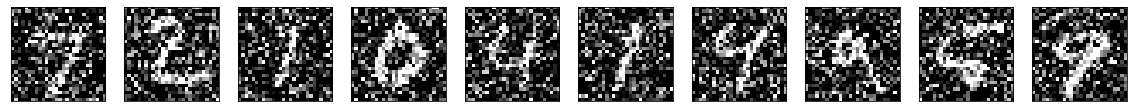

In [6]:
n = 10
plt.figure(figsize=(20, 2))

for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

#### 模型建立

\# 28 * 28 * 1 >>> # 28 * 28 * 32 >>> # 14 * 14 * 32 >>> # 14 * 14 * 32 >>> # 7 * 7 * 32

\# 7 * 7 * 32 >>> # 14 * 14 * 32 >>> # 14 * 14 * 32 >>> # 28 * 28 * 32 >>> 28 * 28 * 1

In [7]:
input_img = Input(shape=(28, 28, 1, ))

x = Conv2D(32, (3, 3), padding='same', activation='relu')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), padding='same', activation='relu')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

autoencoder = Model(input_img, decoded)
# 最小化图像重构损失
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, 
                          x_train,
                          epochs=100,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))

In [ ]:
# 保存
autoencoder.save('autoencoder.h5')

#### 预测

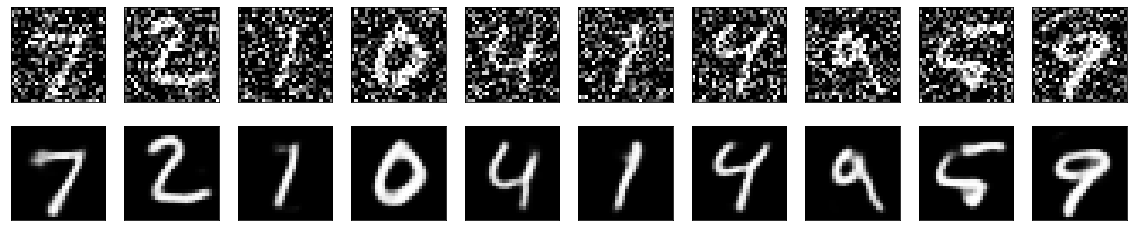

In [9]:
autoencoder = load_model('autoencoder.h5')

decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()